In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
edu_wage10 = pd.read_csv("data/pums/processed/10_edu_wage_data.csv")
edu_wage12 = pd.read_csv("data/pums/processed/12_edu_wage_data.csv")
edu_wage14 = pd.read_csv("data/pums/processed/14_edu_wage_data.csv")
edu_wage16 = pd.read_csv("data/pums/processed/16_edu_wage_data.csv")
edu_wage18 = pd.read_csv("data/pums/processed/18_edu_wage_data.csv")

In [3]:
edu_wage14.head()
# np.unique(edu_wage14["FOD1P"])

,ADJINC,PWGTP,AGEP,CIT,COW,ENG,SCHL,SEX,WAGP,WKHP,WKW,ESR,FOD1P,FOD2P,PERNP
0,1008425,249,40,1,1.0,NaN,22.0,1,97000,40,1.0,1.0,2407.0,NaN,97000
1,1008425,152,35,5,3.0,2.0,24.0,2,0,,NaN,6.0,3600.0,NaN,0
2,1008425,81,67,1,4.0,NaN,23.0,1,150000,40,1.0,1.0,3202.0,NaN,150000
3,1008425,88,67,1,4.0,NaN,24.0,2,0,,NaN,6.0,3600.0,NaN,0
4,1008425,285,41,1,1.0,NaN,21.0,2,40000,45,1.0,1.0,6107.0,NaN,40000


In [4]:
grad_students = pd.read_csv("data/fivethiryeight/grad-students.csv")
grad_students = grad_students[["Major_code", "Major", "Major_category"]]
grad_students.head()

,Major_code,Major,Major_category
0,5601,CONSTRUCTION SERVICES,Industrial Arts & Consumer Services
1,6004,COMMERCIAL ART AND GRAPHIC DESIGN,Arts
2,6211,HOSPITALITY MANAGEMENT,Business
3,2201,COSMETOLOGY SERVICES AND CULINARY ARTS,Industrial Arts & Consumer Services
4,2001,COMMUNICATION TECHNOLOGIES,Computers & Mathematics


In [5]:
majors_list = pd.read_csv("data/fivethiryeight/majors-list.csv")
majors_list = majors_list[majors_list["FOD1P"] != "bbbb "]
majors_list["FOD1P"] = pd.to_numeric(majors_list["FOD1P"])
majors_list.head()

,FOD1P,Major,Major_Category
0,1100,GENERAL AGRICULTURE,Agriculture & Natural Resources
1,1101,AGRICULTURE PRODUCTION AND MANAGEMENT,Agriculture & Natural Resources
2,1102,AGRICULTURAL ECONOMICS,Agriculture & Natural Resources
3,1103,ANIMAL SCIENCES,Agriculture & Natural Resources
4,1104,FOOD SCIENCE,Agriculture & Natural Resources


# How to gain the largest profit from college 

## 1a. Popular major

In [7]:
# function to combine two datasets then we have a new dataset with defined values instead of integer value
def combine2table(table1, table2):
    table1 = table1.dropna(axis = 0)
    
    # convert employment structure
    result = table1.set_index('FOD1P').join(table2.set_index('FOD1P')).reset_index()
    
    # self-employed is not counted as employed
    result["COW"] = np.where((result["COW"] == 9) | (result["COW"] == 8) | \
                             (result["COW"] == 7) | (result["COW"] == 6), "Unemployed", "Employed")
    
    # Rename the major to first degree
    result = result.rename(columns = {"Major": "First_degree"})
    
    # Give name to variable SEX
    result["SEX"] = np.where(result["SEX"] == 1, "Male", "Female")
    
    return result

In [8]:
new_edu_wage10 = combine2table(edu_wage10, majors_list)
new_edu_wage12 = combine2table(edu_wage12, majors_list)
new_edu_wage14 = combine2table(edu_wage14, majors_list)
new_edu_wage16 = combine2table(edu_wage16, majors_list)
new_edu_wage18 = combine2table(edu_wage18, majors_list)
new_edu_wage10.head()

,FOD1P,ADJINC,PWGTP,AGEP,CIT,COW,ENG,SCHL,SEX,WAGP,WKHP,WKW,ESR,FOD2P,PERNP,First_degree,Major_Category
0,1100.0,1007624,89,48,4,Employed,1.0,21.0,Female,71000.0,40.0,1.0,1.0,6207.0,71000.0,GENERAL AGRICULTURE,Agriculture & Natural Resources
1,1100.0,1007624,72,75,4,Employed,2.0,21.0,Male,21000.0,40.0,1.0,1.0,1101.0,21000.0,GENERAL AGRICULTURE,Agriculture & Natural Resources
2,1100.0,1007624,23,49,1,Unemployed,1.0,22.0,Male,0.0,48.0,1.0,1.0,6203.0,37500.0,GENERAL AGRICULTURE,Agriculture & Natural Resources
3,1100.0,1007624,19,52,1,Employed,2.0,21.0,Male,100000.0,40.0,1.0,1.0,6203.0,100000.0,GENERAL AGRICULTURE,Agriculture & Natural Resources
4,1100.0,1007624,65,28,5,Employed,1.0,23.0,Female,13000.0,40.0,5.0,3.0,6201.0,13000.0,GENERAL AGRICULTURE,Agriculture & Natural Resources


In [9]:
len(np.unique(new_edu_wage18["First_degree"])), len(np.unique(new_edu_wage18["Major_Category"]))

(169, 16)

#### Employment rate after college

In [15]:
employment_df = new_edu_wage10.copy()
# count the total number of people in that major category
total_num_mtx = employment_df[["Major_Category", "COW"]].groupby("Major_Category").count().values
# count the total number of major category
length = new_edu_wage10.copy()[["Major_Category", "COW"]].groupby("Major_Category").count().shape[0]
# doubling the size as it excludes the sex columns
total_num = np.repeat(total_num_mtx, 2).reshape(length * 2, 1)
# selected the variables we need
employment_df = employment_df[["Major_Category", "SEX", "COW"]]
# count the number of males and females in different category
employment_df = employment_df.groupby(["Major_Category", "SEX"]).count()
# calculate the rate
employment_df["employment_rate"] = employment_df.values / total_num
employment_df = employment_df.reset_index()
employment_df = employment_df.drop("COW", axis = 1)
employment_df.head()

,Major_Category,SEX,employment_rate
0,Agriculture & Natural Resources,Female,0.424779
1,Agriculture & Natural Resources,Male,0.575221
2,Arts,Female,0.589286
3,Arts,Male,0.410714
4,Biology & Life Science,Female,0.512409


Text(0.5, 1.0, 'Employment Rate for Each Major Category in 2010')

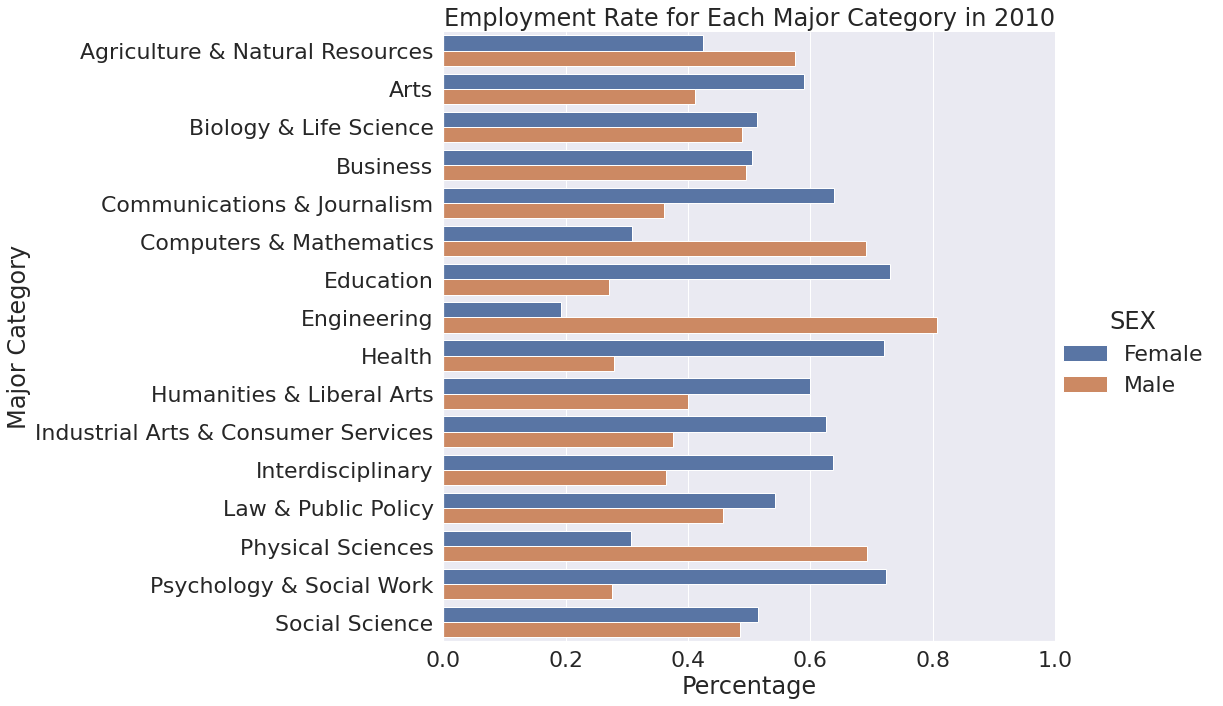

In [23]:
# Barplot to see which major category has the highest employment rate
g = sns.catplot(y = "Major_Category", x = 'employment_rate', hue = "SEX", kind = 'bar', 
                data = employment_df,
                height = 10, aspect = 1.6)
g.ax.set_xlim(0, 1)
sns.set(font_scale = 2)
g.ax.set_xlabel("Percentage")
g.ax.set_ylabel("Major Category")
g.ax.set_title("Employment Rate for Each Major Category in 2010")

The major categories that have the highest employment rate are Computers & Mathematics, Engineering, and Physical Sciences. To investigate more, we will explore more into the major degree instead of the major category.

## Create a function for the above work, convenient for plotting in other years

In [191]:
def employment_rate_plot(table1, year):
    
    table_copy = table1.copy()
    
    # selected the variables we need
    employment_df = table_copy[["Major_Category", "SEX", "COW"]]
    
    # create an index column
    employment_df["index"] = table_copy.index
    
    # count the number of males and females in different category
    employment_df = employment_df.groupby(["Major_Category", "SEX", "COW"]).count().reset_index()
    
    # count the total number of people in that major category
    total_num_mtx = table_copy[["Major_Category", "COW", "SEX"]].groupby(["Major_Category", "SEX"]).count().reset_index()
    total_num_mtx = total_num_mtx.rename(columns = {"COW": "total"})
    final_df = employment_df.merge(total_num_mtx, on = "Major_Category", how = "left")
    final_df = final_df[final_df["SEX_x"] == final_df["SEX_y"]]

    # calculate the rate
    final_df["employment_rate"] = final_df["index"] / final_df["total"]
    final_df = final_df[final_df["COW"] == "Unemployed"]
    final_df = final_df.drop(["COW", "SEX_y", "index", "total"], axis = 1)
    final_df = final_df.rename(columns = {"SEX_x": "Gender"})
    
    # plot
    # Barplot to see which major category has the highest employment rate
    g = sns.catplot(y = "Major_Category", x = 'employment_rate', hue = "Gender", kind = 'bar', 
                    data = final_df,
                    height = 10, aspect = 1.6)
    g.ax.set_xlim(0, 1)
    sns.set(font_scale = 2)
    g.ax.set_xlabel("Percentage")
    g.ax.set_ylabel("Major Category")
    g.ax.set_title("Employment Rate for Each Major Category in "+ str(year))

/tmp/ipykernel_2544/2829048852.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employment_df["index"] = table_copy.index


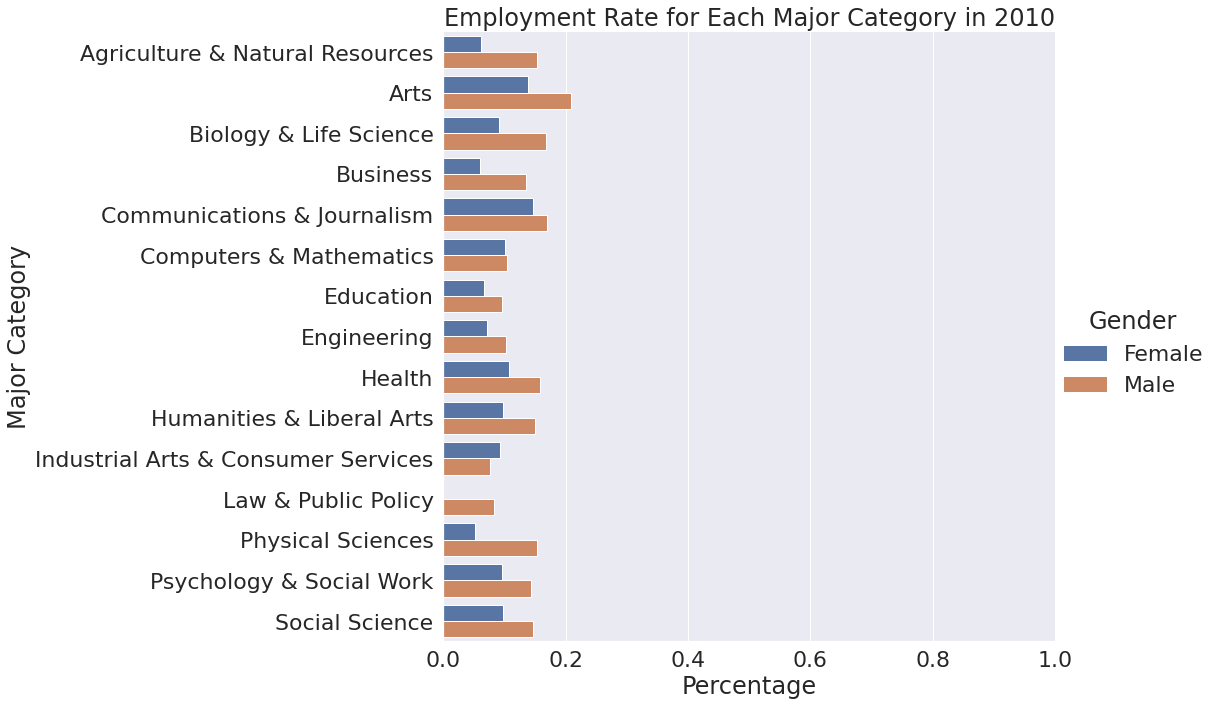

In [192]:
# testing the function
employment_rate_plot(new_edu_wage10, 2010)

In [62]:
def employment_rate_plot2(table1, year):
    
    table_copy = table1.copy()
    
    # selected the variables we need
    employment_df = table_copy[["Major_Category", "COW"]]
    
    # create an index column
    employment_df["index"] = table_copy.index
    
    # count the number of males and females in different category
    employment_df = employment_df.groupby(["Major_Category", "COW"]).count().reset_index()
    
    # count the total number of people in that major category
    total_num_mtx = table_copy[["Major_Category", "COW"]].groupby("Major_Category").count().reset_index()
    total_num_mtx = total_num_mtx.rename(columns = {"COW": "total"})
    final_df = employment_df.merge(total_num_mtx, on = "Major_Category", how = "left")
    
    # drop the major that had less than 50 people
    final_df = final_df[final_df["total"] >= 50]

    # # calculate the rate
    final_df["employment_rate"+str(year)] = final_df["index"] / final_df["total"] * 100
    final_df = final_df[final_df["COW"] == "Employed"]
    final_df = final_df.drop(["COW", "index", "total"], axis = 1)
    # final_df = final_df.rename(columns = {"SEX_x": "Gender"})
    return final_df
    # plot
    # Barplot to see which major category has the highest employment rate
    # g = sns.catplot(y = "Major_Category", x = 'employment_rate', kind = 'bar', 
    #                 data = final_df,
    #                 height = 10, aspect = 1.6)
    # g.ax.set_xlim(0, 1)
    # sns.set(font_scale = 2)
    # g.ax.set_xlabel("Percentage")
    # g.ax.set_ylabel("Major Category")
    # g.ax.set_title("Employment Rate for Each Major Category in "+ str(year))

## Which major categories have the stable demand of careers over time? 

In [186]:
wage_data_dict = {12: new_edu_wage12, 14: new_edu_wage14, \
                  16: new_edu_wage16, 18: new_edu_wage18}

employment_rate_df = employment_rate_plot2(new_edu_wage10, 2010)
for key in wage_data_dict:
    new_employment_df = employment_rate_plot2(wage_data_dict[key], 2000+key)
    employment_rate_df = employment_rate_df.merge(new_employment_df, on = "Major_Category", how = "left")

employment_rate_df.head()

/tmp/ipykernel_11213/3147281052.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employment_df["index"] = table_copy.index


,Major_Category,employment_rate2010,employment_rate2012,employment_rate2014,employment_rate2016,employment_rate2018
0,Agriculture & Natural Resources,88.495575,82.978723,77.659574,89.062500,88.275862
1,Arts,83.214286,77.215190,83.272727,81.415929,83.816425
2,Biology & Life Science,87.153285,87.136929,89.120715,88.154613,89.912281
3,Business,90.271226,89.277523,88.256441,89.851076,89.267849
4,Communications & Journalism,84.548105,85.863874,86.908078,84.459459,88.823529


In [187]:
employment_sd = employment_rate_df.std(axis = 1).values
employment_rate_df["sd"] = employment_sd
# filter out the sd that are greater than 1.5
employment_rate_df = employment_rate_df[employment_rate_df["sd"] < 1.5]
employment_rate_df = employment_rate_df.drop("sd", axis = 1)
employment_rate_df.head()

/tmp/ipykernel_11213/2498852426.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  employment_sd = employment_rate_df.std(axis = 1).values


,Major_Category,employment_rate2010,employment_rate2012,employment_rate2014,employment_rate2016,employment_rate2018
2,Biology & Life Science,87.153285,87.136929,89.120715,88.154613,89.912281
3,Business,90.271226,89.277523,88.256441,89.851076,89.267849
5,Computers & Mathematics,89.638932,88.727858,91.743119,90.942928,90.605428
6,Education,92.540323,92.506460,90.450928,91.666667,90.799031
7,Engineering,90.336134,91.549296,93.349456,91.420118,93.387681


In [188]:
employment_rate_df = employment_rate_df.set_index("Major_Category")
employment_rate_df = employment_rate_df.T
employment_rate_df = employment_rate_df.reset_index()
employment_rate_df.head()

Major_Category,index,Biology & Life Science,Business,Computers & Mathematics,Education,Engineering,Health,Humanities & Liberal Arts,Physical Sciences,Social Science
0,employment_rate2010,87.153285,90.271226,89.638932,92.540323,90.336134,87.867647,88.072122,87.810384,87.816307
1,employment_rate2012,87.136929,89.277523,88.727858,92.506460,91.549296,91.449814,88.503401,87.616822,88.547486
2,employment_rate2014,89.120715,88.256441,91.743119,90.450928,93.349456,90.725806,87.914517,85.989011,89.548023
3,employment_rate2016,88.154613,89.851076,90.942928,91.666667,91.420118,90.353698,87.981711,89.195980,87.190083
4,employment_rate2018,89.912281,89.267849,90.605428,90.799031,93.387681,90.909091,88.801927,87.968442,88.619855


In [189]:
# employment_sd = employment_rate_df.std().values
# employment_rate_df["sd"] = employment_sd.reshape(len(employment_sd), 1)
# employment_rate_df

([<matplotlib.axis.XTick at 0x7feac443c4f0>,
 [Text(0, 0, '2010'),
  Text(1, 0, '2012'),
  Text(2, 0, '2014'),
  Text(3, 0, '2016'),
  Text(4, 0, '2018')])

<Figure size 7200x288 with 0 Axes>

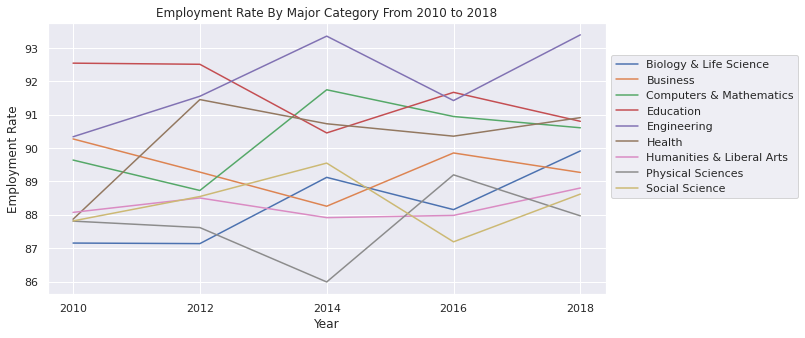

In [190]:
plt.figure(figsize=(100,4))
employment_rate_df.plot(figsize = (10, 5), xticks = np.arange(0, 5, 1),
                        title = "Employment Rate By Major Category From 2010 to 2018",
                        xlabel = "Year", ylabel = "Employment Rate")
plt.legend(bbox_to_anchor = (1, 0.5, 0.1, 0.4), loc = 'upper left')
plt.xticks(np.arange(0, 5, 1), ["2010", "2012", "2014", "2016", "2018"])

In [112]:
# len(np.unique(edu_wage12["WAGP"])), len(np.unique(edu_wage12["WAGP"]))
# edu_wage12["WAGP"]
# employment_rate_plot2(new_edu_wage12, 2012)

In [19]:
# edu_wage18["WAGP"]
# len(np.unique(edu_wage18["WAGP"])),len(np.unique(edu_wage16["WAGP"])),len(np.unique(edu_wage14["WAGP"]))

In [8]:
recent_grad_stats10 = pd.read_csv("data/pums/processed/2010_recent_grad_stats_by_major.csv")
recent_grad_stats12 = pd.read_csv("data/pums/processed/2012_recent_grad_stats_by_major.csv")
recent_grad_stats14 = pd.read_csv("data/pums/processed/2014_recent_grad_stats_by_major.csv")
recent_grad_stats16 = pd.read_csv("data/pums/processed/2016_recent_grad_stats_by_major.csv")
recent_grad_stats18 = pd.read_csv("data/pums/processed/2018_recent_grad_stats_by_major.csv")

In [28]:
recent_grad_stats14.head()

,FOD1P,total,men,women,total median,women median,men median,Major,Major_Category
0,1100.0,12132,7197,4935,36443,37159,35833,GENERAL AGRICULTURE,Agriculture & Natural Resources
1,1101.0,13372,8483,4889,35000,30000,40000,AGRICULTURE PRODUCTION AND MANAGEMENT,Agriculture & Natural Resources
2,1102.0,2208,1675,533,48167,34793,50000,AGRICULTURAL ECONOMICS,Agriculture & Natural Resources
3,1103.0,24388,5936,18452,33109,34041,28691,ANIMAL SCIENCES,Agriculture & Natural Resources
4,1104.0,4644,1414,3230,43773,46624,37060,FOOD SCIENCE,Agriculture & Natural Resources


## What would bring you if you get a higher level of education?